In [76]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LinearRegression
from sklearn.preprocessing import Imputer, MaxAbsScaler, RobustScaler, StandardScaler

In [2]:
def evaluate(actual, pred):
    """Computes the R value of the predictions given the actual values.
    
    Both actual and pred should be of the same length where each index
    corresponds to the actual and predicted value of the same row of data.
    
    Args:
        actual: A list of actual values.
        pred: A list of predicted values.
    
    Returns:
        R value of the predictions given the actual values.
    """
    assert len(actual) == len(pred)
    nume = np.sum(np.square(actual - pred))
    denom = np.sum(np.square(actual - np.mean(actual)))
    r_sq = 1 - nume / denom
    r_score =  np.sign(r_sq) * np.sqrt(np.abs(r_sq))

    print('======================')
    print('Evaluation results....')
    print('Min pred: ', min(pred), ', Max pred: ', max(pred))
    for percent in range(10, 100, 10):
        print('Percentile ', percent, ': ', np.percentile(pred, percent))
        
    print('Min actual: ', min(actual), ', Max actual: ', max(actual))
    for percent in range(10, 100, 10):
        print('Percentile ', percent, ': ', np.percentile(actual, percent))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    pd.Series(pred).hist(bins=100, range=(np.percentile(pred, 5), np.percentile(pred, 95)), ax=ax1)
    ax1.set_title('Predicted values')
    pd.Series(actual).hist(bins=100, range=(np.percentile(actual, 5), np.percentile(actual, 95)), ax=ax2)
    ax2.set_title('Actual values')
    plt.show()
    
    return r_score

In [83]:
class Model(object):
    """A generic Model interface to encapsulate modeling and data processing.
    
    Attributes:
        model_: A sklearn model with two function interfaces - fit, predict.
        imputer_: A sklearn preprocessing model to perform imputation for missing values.
        normalizer_: A sklearn preprocessing model to normalize feature values.
        columns_: List of column names corresponding to the features.
    """
    def __init__(self, model=None, imputer=None, normalizer=None):
        """Initialize the Model class with the given model.
        
        Args:
            model: A sklearn model.
            imputer: Transformer for missing values.
            normalizer: Normalizer for the feature values.
        """
        self.model_ = model
        self.imputer_ = imputer
        self.normalizer_ = normalizer
        
    def fit(self, df, low_y_cut=-0.0860917, high_y_cut=0.093492):
        """Fit the underlying model with the given data frame.
        
        Args:
            df: Dataframe object containing the underlying data. It has three
                special columns - id, y (label), timestamp.
        """
        # FILTER ROWS.
        # Remove training data with outlier y found when plotting the histogram.
        # It is likely that there are some threshold of y that cause automatic
        # stocks to be removed from portfolio such as stop loss etc.
        whitelisted_inds = ((df['y'] > low_y_cut) & (df['y'] < high_y_cut))
        X_train = df.loc[whitelisted_inds, :]
        Y_train = X_train['y']

        # FILTER COLUMNS
        # Drops the three special columns.
        X_train = X_train.drop(['id', 'y', 'timestamp'], axis=1)
        # Use only the technical columns.
        X_train = X_train.filter(regex='technical_*', axis=1)
        self.columns_ = X_train.columns
        
        # Imputes the missing value.
        if self.imputer_:
            X_train = self.imputer_.fit_transform(X_train)
        else:
            # Fill with 0 if there is no imputer.
            X_train = X_train.fillna(0)
        
        # Normalizes the feature values.
        if self.normalizer_:
            X_train = self.normalizer_.fit_transform(X_train)

        self.model_.fit(X_train, Y_train)
        
        # Save the min / max of y to threshold the prediction from going above the range.
        self.min_y_ = min(df['y'])
        self.max_y_ = max(df['y'])
    
    def predict(self, df):
        """Infers the predictions for the given df features.
        
        Args:
            df: Dataframe object containing the data features to be predicted. It has
                two special columns - id, timestamp.
        
        Returns:
            The predictions for each of the row in df, in the same order as given.
        """
        X_pred = df.drop(['id', 'timestamp'], axis=1)
        X_pred = X_pred.filter(regex='technical_*', axis=1)
        
        # Imputes the missing value.
        if self.imputer_:
            X_pred = self.imputer_.transform(X_pred)
        else:
            # Fill with 0 if there is no imputer.
            X_pred = X_pred.fillna(0)
        
        # Normalizes the feature values.
        if self.normalizer_:
            X_pred = self.normalizer_.transform(X_pred)
        
        # Hack: Threshold each y between (self.min_y_, self.max_y_) to avoid outlier features from killing
        # the predictions, causing some huge R values.
        return list(map(
            lambda y: self.min_y_ if y < self.min_y_ else min(y, self.max_y_),
            self.model_.predict(X_pred)))
    
    def visualize(self):
        """Visualize the underlying learned model."""
        pass

In [84]:
class LinearModel(Model):
    """Wrapper around sklearn.linear_model.
    """
    def visualize(self):
        try:
            assert len(self.columns_) == len(self.model_.coef_), \
            "# columns: %d vs # coeff: %d" % (len(self.columns_), len(self.model_.coef_))
            print('Bias: ', self.model_.intercept_)
            for (ind, column) in enumerate(self.columns_):
                print(column, ': ', self.model_.coef_[ind])
        except:
            return

In [42]:
class EnsembleModel(Model):
    """Wrapper around sklearn.ensemble.
    """
    def visualize(self):
        try:
            assert len(self.columns_) == len(self.model_.feature_importances_), \
            "# columns: %d vs # features: %d" % (len(self.columns_), len(self.model_.feature_importances_))
            for (ind, column) in enumerate(self.columns_):
                print(column, ': ', self.model_.feature_importances_[ind])
        except:
            return

In [86]:
def train_model(train_df):
    """Returns a new model trained using the given data frame.

    Args:
        train_df: DataFrame object corresponding to training data.
    
    Returns:
        Model trained using the data frame.
    """
    model = LinearModel(
        model=Lasso(alpha=1e-4),
        imputer=Imputer(strategy='median'),
        normalizer=StandardScaler())
    model.fit(train_df, low_y_cut=-1, high_y_cut=1)
    return model

In [7]:
def run_infer(model, features, target):
    """Populates the target using the features and model and updates the
    model.
    
    Args:
        model: A model for prediction and then for updating with new data.
        features: DataFrame object corresponding to new data to predict
                  on, and then update the existing model.
        target: DataFrame object containing id and the y value to be updated
                with.
    """
    # Verify that the features and targets are aligned.
    assert len(features) == len(target)
    assert (features['id'] == target['id']).all()

    # Set the target value to the one given.
    target['y'] = model.predict(features)
    return target

Bias:  0.00025588435623
technical_0 :  0.0
technical_1 :  0.0
technical_2 :  -0.0
technical_3 :  0.0
technical_5 :  -0.0
technical_6 :  -0.0
technical_7 :  -2.93412439067e-05
technical_9 :  -0.0
technical_10 :  -0.0
technical_11 :  -0.0
technical_12 :  -0.0
technical_13 :  -0.0
technical_14 :  -0.0
technical_16 :  -0.0
technical_17 :  -0.0
technical_18 :  -0.0
technical_19 :  -4.05688497187e-05
technical_20 :  -0.000173065952102
technical_21 :  -0.0
technical_22 :  0.0
technical_24 :  0.0
technical_25 :  -0.0
technical_27 :  -0.0
technical_28 :  -0.0
technical_29 :  -0.0
technical_30 :  0.000228483240514
technical_31 :  -0.0
technical_32 :  -0.0
technical_33 :  -0.0
technical_34 :  -0.0
technical_35 :  -0.0
technical_36 :  -0.0
technical_37 :  0.0
technical_38 :  -0.0
technical_39 :  -0.0

/Users/chunhowt/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



technical_40 :  -5.20689898335e-05
technical_41 :  -0.0
technical_42 :  -0.0
technical_43 :  -0.0
technical_44 :  0.0
Evaluation results....
Min pred:  -0.00390403701976 , Max pred:  0.00638043194726
Percentile  10 :  -7.27040725972e-05
Percentile  20 :  6.59231666809e-05
Percentile  30 :  0.000150667925735
Percentile  40 :  0.000225575113525
Percentile  50 :  0.000270605963834
Percentile  60 :  0.000299520168228
Percentile  70 :  0.000332959845514
Percentile  80 :  0.000414159370437
Percentile  90 :  0.000566811876404
Min actual:  -0.0860941 , Max actual:  0.0934978
Percentile  10 :  -0.0216139292344
Percentile  20 :  -0.0121857544407
Percentile  30 :  -0.00703797708265
Percentile  40 :  -0.0032957540825
Percentile  50 :  -6.80844505041e-06
Percentile  60 :  0.00333191393875
Percentile  70 :  0.00716497898102
Percentile  80 :  0.0124006709084
Percentile  90 :  0.0221050107852


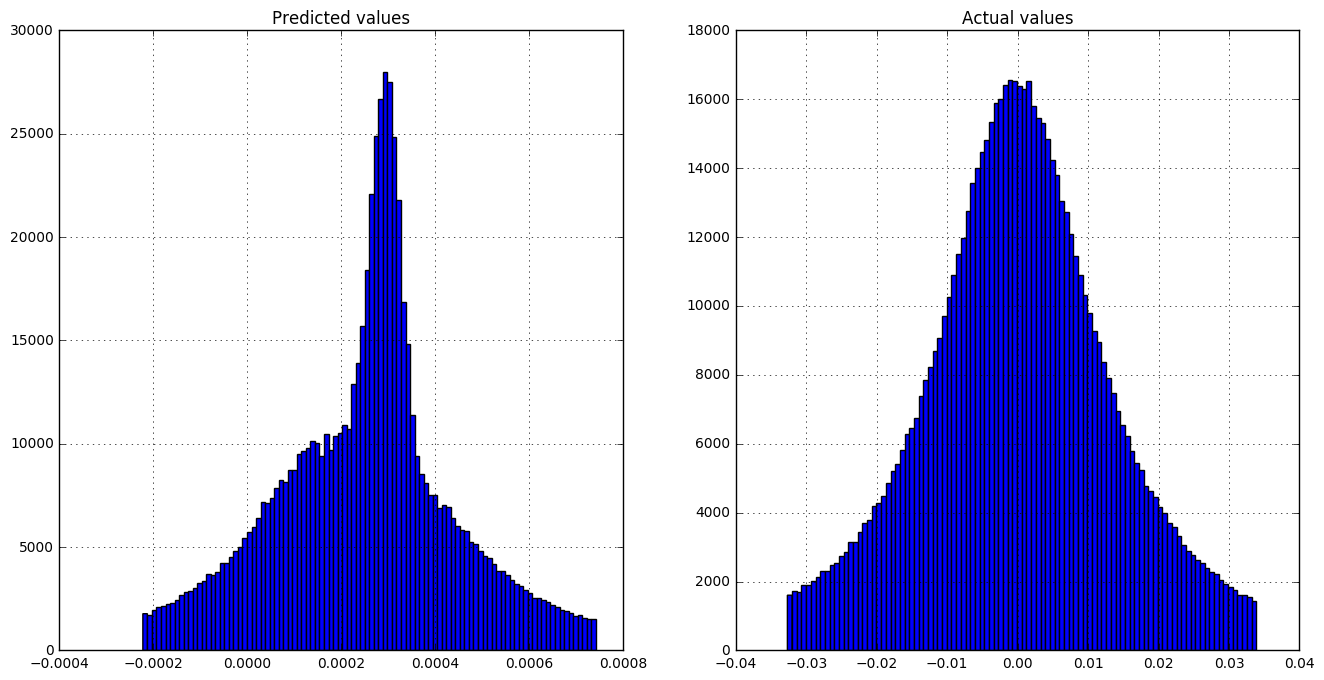

Training R score:  0.0210376657028
Evaluation results....
Min pred:  -0.00402968482183 , Max pred:  0.00537168586992
Percentile  10 :  -0.000101599609543
Percentile  20 :  4.6769675407e-05
Percentile  30 :  0.000139672355346
Percentile  40 :  0.000209964398956
Percentile  50 :  0.0002554958619
Percentile  60 :  0.000287097335236
Percentile  70 :  0.000330664034253
Percentile  80 :  0.000432677153049
Percentile  90 :  0.0005935668063
Min actual:  -0.0860941 , Max actual:  0.0934978
Percentile  10 :  -0.0224128818139
Percentile  20 :  -0.0126877807081
Percentile  30 :  -0.0074104225263
Percentile  40 :  -0.00357656376436
Percentile  50 :  -0.000293691977276
Percentile  60 :  0.00305591947399
Percentile  70 :  0.00703587168828
Percentile  80 :  0.0126516038552
Percentile  90 :  0.0232857193798


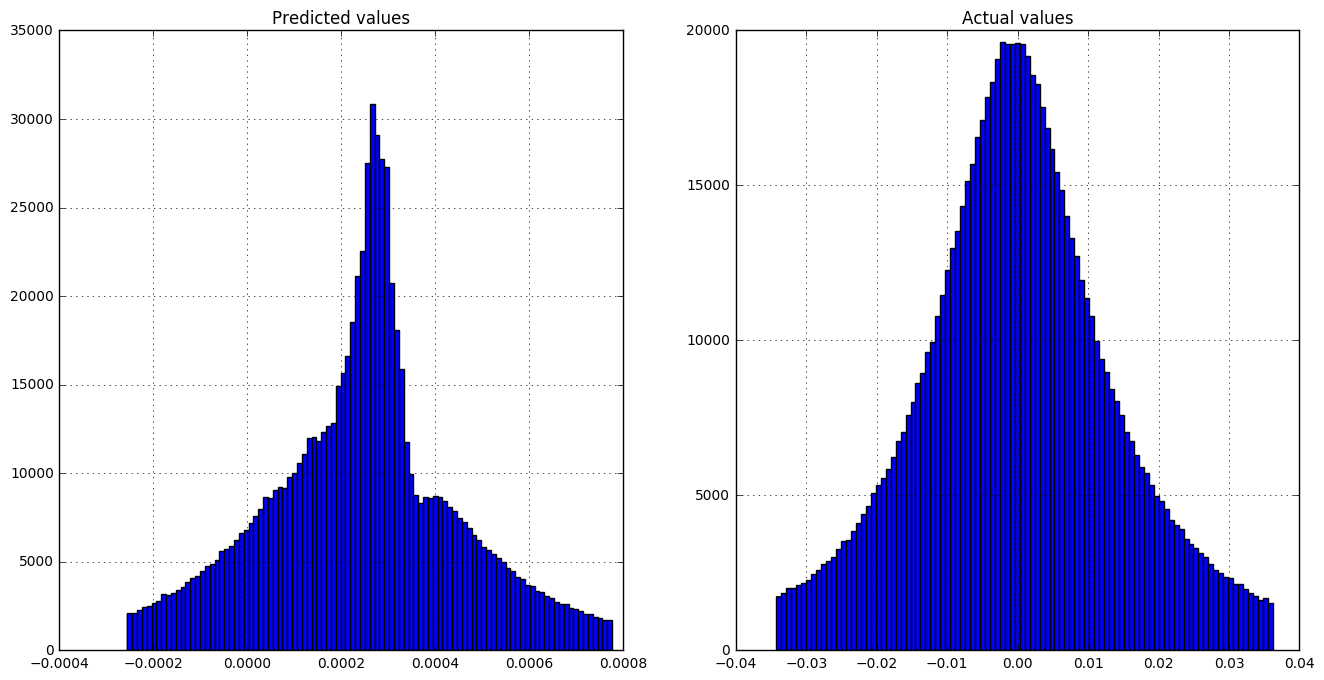

Validation R score:  0.0178753811318


In [87]:
# A cell to perform local E2E training and prediction that simulates
# the KaggleGym behavior.
def localE2E(run_validation=True, visualize_model=False):
    """A function to simulate KaggleGym behavior of predicting per timestep.
    """
    # Here's an example of loading the CSV using Pandas's built-in HDF5 support:
    with pd.HDFStore("train.h5", "r") as train:
        # Note that the "train" dataframe is the only dataframe in the file
        df = train.get("train")
        train_df = df[:806298]
        valid_df = df[806298:]
    
    # NOTE: Training goes here.
    model = train_model(train_df)
    if visualize_model:
        model.visualize()

    train_preds = run_infer(
        model,
        train_df.drop(['y'], axis=1),
        train_df[['id', 'y']])
    print('Training R score: ', evaluate(train_df['y'], train_preds['y']))
    
    if not run_validation:
        return 0
    
    # Validation goes here.
    predictions = []
    curr_timestamp = 0
    curr_data = []
    curr_target = []
    for row in valid_df.itertuples():
        # If it is a new timestamp, predict.
        if row.timestamp != curr_timestamp:
            if curr_data:
                # NOTE: Inference and updating goes here.
                new_targets = run_infer(
                    model,
                    # Drop the last column (y).
                    pd.DataFrame(curr_data, columns=valid_df.columns[:-1]),
                    pd.DataFrame(curr_target, columns=['id', 'y']))
                predictions.extend(list(new_targets['y']))
            # Reset arrays.
            curr_data = []
            curr_target= []
            curr_timestamp = row.timestamp
        # Drop the first (index) and last (y) into features.
        curr_data.append(list(row)[1:-1])
        curr_target.append([row.id, 0])

    # Infer for the last timestamp.
    new_targets = run_infer(
        model,
        # Drop the last column (y).
        pd.DataFrame(curr_data, columns=valid_df.columns[:-1]),
        pd.DataFrame(curr_target, columns=['id', 'y']))

    predictions.extend(list(new_targets['y']))
    return evaluate(valid_df['y'], predictions)

print('Validation R score: ', localE2E(run_validation=True, visualize_model=True))

In [ ]:
# Read data from Kagglegym
import kagglegym

def kaggleE2E():
    """Runs Kaggle training and predictions E2E.
    """
    # Create env.
    env = kagglegym.make()
    # Get first observation.
    observation = env.reset()
    # Get train data.
    train_df = observation.train
    model = train_model(train_df)

    # Predict using Kagglegym.
    while True:
        predictions = run_infer(model, observation.features, observation.target)
        observation, reward, done, info = env.step(predictions)
        # print('Reward: ', reward)
        if done:
            break
    print(info)

kaggleE2E()